Dataset loaded successfully!

--- First 5 rows of the dataset ---
   make_year  mileage_kmpl  engine_cc fuel_type  owner_count  price_usd  \
0       2001          8.17       4000    Petrol            4    8587.64   
1       2014         17.59       1500    Petrol            4    5943.50   
2       2023         18.09       2500    Diesel            5    9273.58   
3       2009         11.28        800    Petrol            1    6836.24   
4       2005         12.23       1000    Petrol            2    4625.79   

       brand transmission  color service_history  accidents_reported  \
0  Chevrolet       Manual  White             NaN                   0   
1      Honda       Manual  Black             NaN                   0   
2        BMW    Automatic  Black            Full                   1   
3    Hyundai       Manual   Blue            Full                   0   
4     Nissan    Automatic    Red            Full                   0   

  insurance_valid  
0              No  
1         

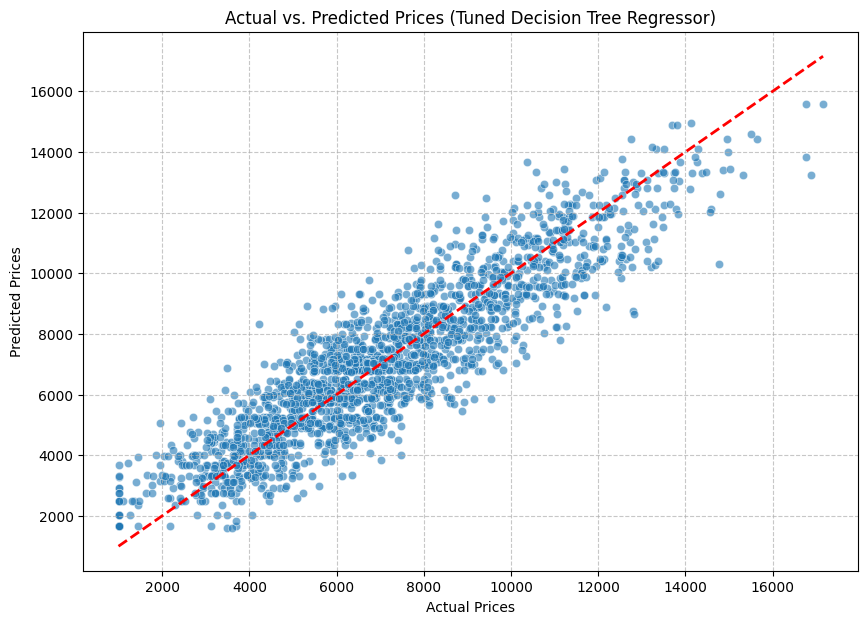

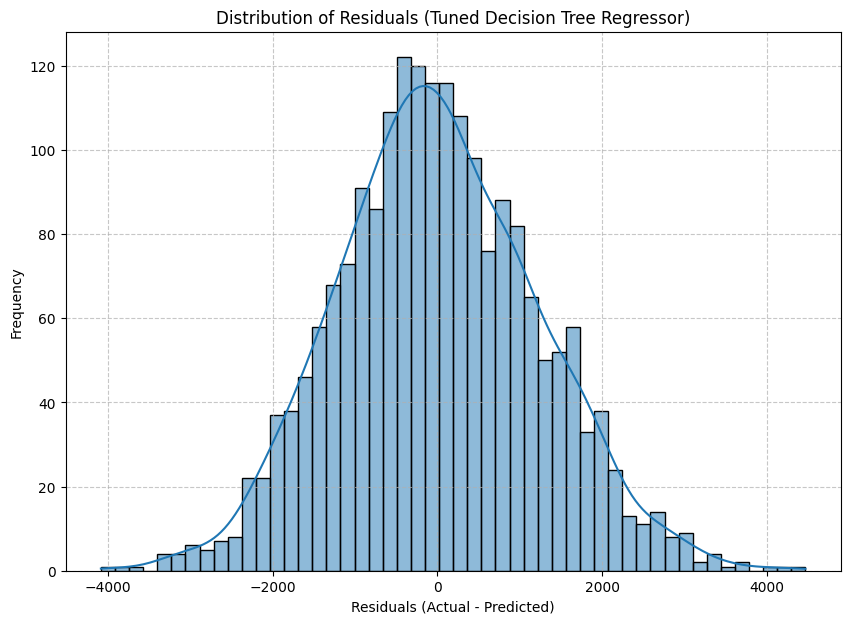

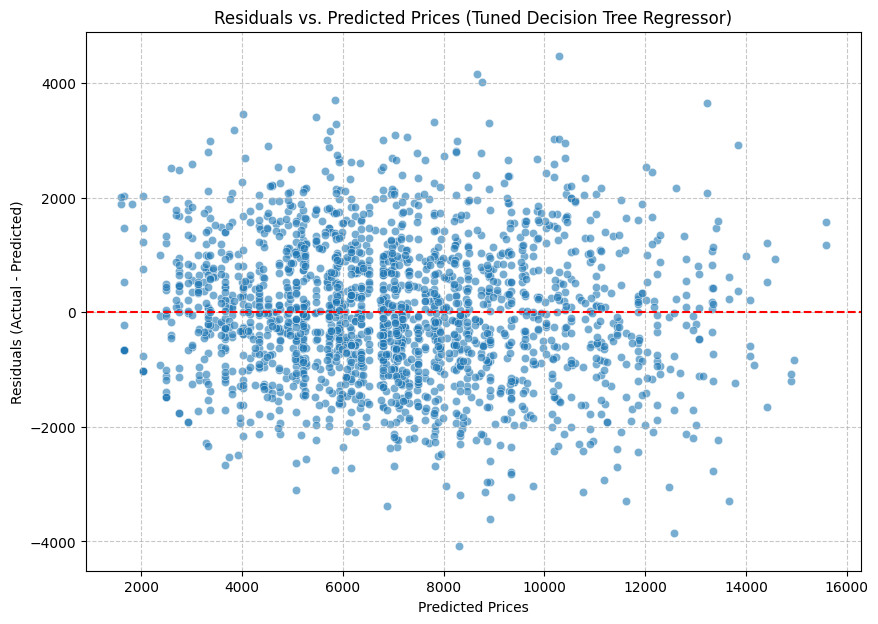


--- Extracting Feature Importances ---

--- Top 10 Feature Importances ---
                    Feature  Importance
2                 engine_cc    0.511624
0                 make_year    0.224256
6        fuel_type_Electric    0.119315
3               owner_count    0.070382
1              mileage_kmpl    0.062615
26     service_history_Full    0.001282
4        accidents_reported    0.001155
27  service_history_Partial    0.001095
28      service_history_nan    0.000977
23                color_Red    0.000873


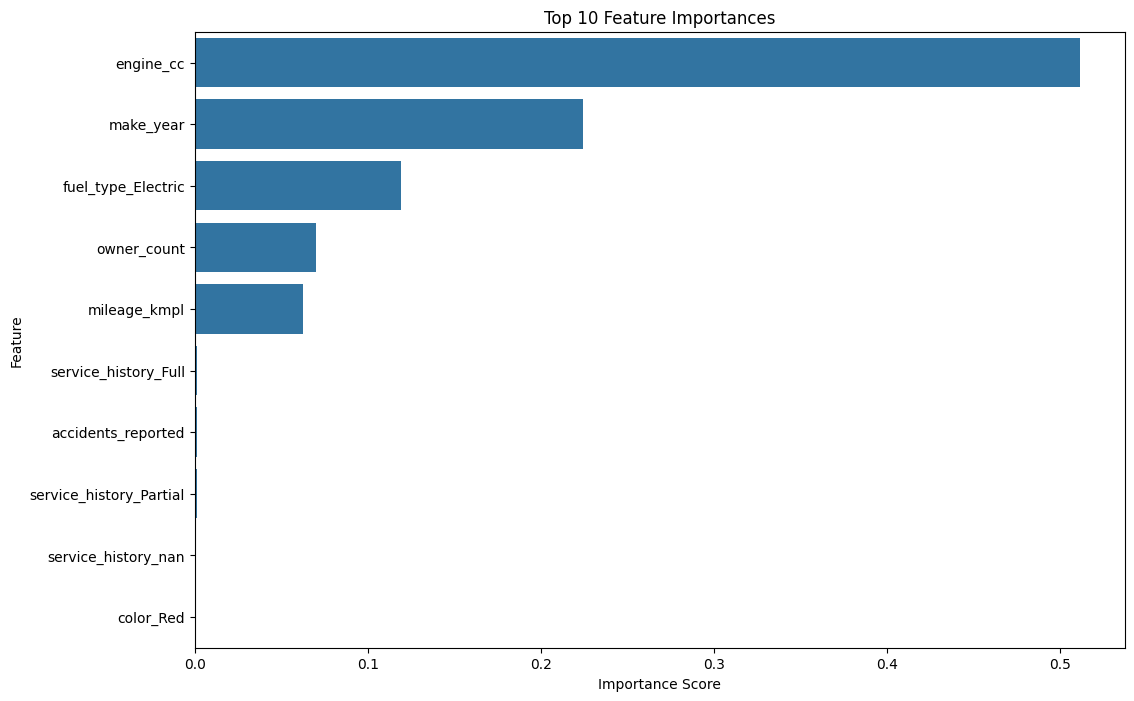

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Data Loading ---
try:
    df = pd.read_csv('car_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'car_dataset.csv' not found. Make sure the file is in the same directory.")
    # You would typically raise an error or exit here in a full script
    exit()

# --- Initial Data Exploration ---
print("\n--- First 5 rows of the dataset ---")
print(df.head())

print("\n--- Dataset Info ---")
df.info()

print("\n--- Descriptive Statistics ---")
print(df.describe())

print("\n--- Missing Values Count ---")
print(df.isnull().sum())

print("\n--- Unique Values for Key Categorical Columns (Example Check) ---")
# Adjust these columns based on your actual df.info()
typical_categorical_cols = ['Brand', 'Model', 'Fuel Type', 'Transmission', 'Ownership', 'Color']
for col in typical_categorical_cols:
    if col in df.columns:
        print(f"\nUnique values in '{col}': {df[col].nunique()}")


# --- Data Preprocessing ---
print("\n--- Starting Data Preprocessing ---")

# 1. Handle 'Unnamed: 0' column if it's an unnecessary index
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    print("Dropped 'Unnamed: 0' column.")

# 2. Impute Missing Values (based on typical dataset patterns)
# Verify these columns based on your df.isnull().sum() output
numerical_cols_to_impute = ['Engine Size', 'Max Power', 'Torque']
categorical_cols_to_impute = ['Fuel Type', 'Transmission']

for col in numerical_cols_to_impute:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_val}")

for col in categorical_cols_to_impute:
    if col in df.columns and df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in '{col}' with mode: {mode_val}")

print("\n--- Missing Values After Handling ---")
print(df.isnull().sum())

# 3. Feature Engineering: Create 'Car_Age' (Week 7 concepts)
if 'Year' in df.columns:
    current_year = pd.Timestamp.now().year
    df['Car_Age'] = current_year - df['Year']
    df.drop('Year', axis=1, inplace=True) # Drop original 'Year' column
    print("\n'Car_Age' feature created and 'Year' column dropped.")
    print(df[['Car_Age', 'Price']].head())
else:
    print("\n'Year' column not found for 'Car_Age' feature engineering.")

# Define categorical and numerical features based on actual columns in X (features only, not target)
categorical_features = ['fuel_type', 'brand', 'transmission', 'color', 'service_history', 'insurance_valid']
numerical_features = ['make_year', 'mileage_kmpl', 'engine_cc', 'owner_count', 'accidents_reported']

# Filter lists to include only columns actually present in X
categorical_features_present = [col for col in categorical_features if col in X.columns]
numerical_features_present = [col for col in numerical_features if col in X.columns]

# Create a ColumnTransformer for flexible preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_present),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_present)
    ],
    remainder='passthrough'
)

print(f"\nDefined numerical features for scaling: {numerical_features_present}")
print(f"Defined categorical features for encoding: {categorical_features_present}")
print("\n--- Data Preprocessing Complete (defined via ColumnTransformer) ---")


# --- Model Selection, Training & Evaluation ---
print("\n--- Starting Model Training & Evaluation ---")

# Define features (X) and target (y)
X = df.drop('price_usd', axis=1) # All columns except 'price_usd'
y = df['price_usd'] # The target variable

# Split the data into training and testing sets (Week 7 concepts)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData split: X_train:{X_train.shape}, X_test:{X_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")

# Function to evaluate models
def evaluate_model(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {model_name} Evaluation ---")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.4f}")
    return mae, rmse, r2

# 1. Linear Regression Model (Week 7)
print("\n--- Training Linear Regression Model ---")
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
mae_lr, rmse_lr, r2_lr = evaluate_model("Linear Regression", y_test, y_pred_lr)

# 2. Decision Tree Regressor Model
print("\n--- Training Decision Tree Regressor Model ---")
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', DecisionTreeRegressor(random_state=42))])
pipeline_dt.fit(X_train, y_train)
y_pred_dt = pipeline_dt.predict(X_test)
mae_dt, rmse_dt, r2_dt = evaluate_model("Decision Tree Regressor", y_test, y_pred_dt)

# 3. Neural Network (MLPRegressor) Model (Week 5)
print("\n--- Training Neural Network (MLPRegressor) Model ---")
pipeline_mlp = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), # 2 layers, 100 and 50 neurons
                                                          activation='relu', # ReLU activation (Week 5)
                                                          solver='adam',     # Adam optimizer
                                                          max_iter=500,      # Max iterations
                                                          random_state=42,
                                                          early_stopping=True, # Prevent overfitting
                                                          n_iter_no_change=20))]) # Patience for early stopping
pipeline_mlp.fit(X_train, y_train)
y_pred_mlp = pipeline_mlp.predict(X_test)
mae_mlp, rmse_mlp, r2_mlp = evaluate_model("Neural Network (MLPRegressor)", y_test, y_pred_mlp)

# 4. Hyperparameter Tuning for Decision Tree Regressor (Example using GridSearchCV - Week 4 concepts)
print("\n--- Hyperparameter Tuning for Decision Tree Regressor using GridSearchCV ---")
param_grid_dt = {
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_dt.fit(X_train, y_train)

print(f"\nBest parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best cross-validation score (negative MSE): {grid_search_dt.best_score_:.2f}")

best_dt_model = grid_search_dt.best_estimator_
y_pred_dt_tuned = best_dt_model.predict(X_test)
mae_dt_tuned, rmse_dt_tuned, r2_dt_tuned = evaluate_model("Tuned Decision Tree Regressor", y_test, y_pred_dt_tuned)


# --- Model Analysis and Visualization ---

# Choose your best performing model's predictions for visualization
# For example, if Tuned Decision Tree was best:
y_preds_best_model = y_pred_dt_tuned # Replace with predictions from your actual best model (e.g., y_pred_mlp)
best_model_name = "Tuned Decision Tree Regressor" # Adjust accordingly

print(f"\n--- Visualizing Performance for {best_model_name} ---")

# Actual vs. Predicted Prices Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_preds_best_model, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs. Predicted Prices ({best_model_name})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Residuals Distribution Plot
residuals = y_test - y_preds_best_model
plt.figure(figsize=(10, 7))
sns.histplot(residuals, kde=True, bins=50)
plt.title(f"Distribution of Residuals ({best_model_name})")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Residuals vs. Predicted Prices Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_preds_best_model, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residuals vs. Predicted Prices ({best_model_name})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Feature Importance (for Tree-based models like Decision Tree) ---
if hasattr(best_dt_model.named_steps['regressor'], 'feature_importances_'): # Check if the regressor has feature_importances_ attribute
    print("\n--- Extracting Feature Importances ---")
    # This part requires reconstructing feature names after preprocessing
    # Get feature names from the preprocessor's transformers
    numerical_ftrs = best_dt_model.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out()
    categorical_ftrs = best_dt_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
    all_feature_names_transformed = list(numerical_ftrs) + list(categorical_ftrs)

    feature_importances = best_dt_model.named_steps['regressor'].feature_importances_
    importance_df = pd.DataFrame({'Feature': all_feature_names_transformed, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 10 Feature Importances ---")
    print(importance_df.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()
else:
    print(f"\nFeature importances are not directly available for {best_model_name} in this manner.")
    print("Consider advanced techniques like Permutation Importance or SHAP values for model-agnostic explanations.")

